In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import re
from sklearn.metrics import multilabel_confusion_matrix
#from pycm import *

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Other
import re
import json
import string
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [167]:
df = pd.read_csv('data/aspect_trial.csv')
review = df.loc[:, ['replace', 'text_lemmatized_without_stopwords', 'comment_sentiment_polarity', 'aspect']]

In [168]:
print(df.groupby('aspect').size().sort_values(ascending=False))

print("number of categories",df.aspect.nunique())

aspect
OTHERS              181
SOCIAL#MENTION      131
MOVIE#GENERAL        98
MOVIE#CHARACTERS     59
SOCIAL#HASHTAG       31
dtype: int64
number of categories 5


In [169]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(review, test_size=0.2, random_state=42)

absa_model = Sequential()
absa_model.add(Dense(512, input_shape=(6000,), activation='relu'))
absa_model.add((Dense(256, activation='relu')))
absa_model.add((Dense(128, activation='relu')))
absa_model.add(Dense(5, activation='softmax'))
#compile model
absa_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train['text_lemmatized_without_stopwords'])
reviews_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(train['text_lemmatized_without_stopwords']))

label_encoder_1 = LabelEncoder()
integer_category = label_encoder_1.fit_transform(train.aspect)
encoded_y = np_utils.to_categorical(integer_category)

print(reviews_tokenized.shape)
print(encoded_y.shape)

(400, 6000)
(400, 5)


In [170]:
#fit aspect classifier
es = EarlyStopping(monitor='loss', mode='auto', patience = 10)
# mc = ModelCheckpoint('data/best_model.h5', monitor='loss', save_best_only=True)

absa_model.fit(reviews_tokenized, encoded_y, epochs=100, verbose=1, callbacks = [es, mc])

Epoch 1/100
400/400 [==============================] - 1s 3ms/step - loss: 1.5303 - accuracy: 0.3450
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 1.2836 - accuracy: 0.4275
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.8408 - accuracy: 0.7100
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.3864 - accuracy: 0.9000
Epoch 5/100
400/400 [==============================] - 1s 1ms/step - loss: 0.1754 - accuracy: 0.9575
Epoch 6/100
400/400 [==============================] - 1s 1ms/step - loss: 0.0621 - accuracy: 0.9850
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0317 - accuracy: 0.9925
Epoch 8/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0221 - accuracy: 0.9950
Epoch 9/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 0.9950
Epoch 10/100
400/400 [==============================] - 1s 2ms/step - loss: 0.0197 - accura

In [171]:
# Aspect preprocessing
test_reviews = [review.lower() for review in test['text_lemmatized_without_stopwords']]
test_aspect_terms = []
for review in nlp.pipe(test_reviews):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    test_aspect_terms.append(' '.join(chunks))
test_aspect_terms = pd.DataFrame(tokenizer.texts_to_matrix(test_aspect_terms))

In [172]:
test_aspect_categories = label_encoder_1.inverse_transform(absa_model.predict_classes(test_aspect_terms))

In [173]:
aspect_acc = sum(test['aspect'] == test_aspect_categories)/len(test_aspect_categories)
print(aspect_acc)

0.51


In [176]:
cm = ConfusionMatrix(actual_vector=np.array(test['aspect']), predict_vector=test_aspect_categories)
multilabel_confusion_matrix(np.array(test['aspect']), test_aspect_categories)

array([[[90,  1],
        [ 7,  2]],

       [[75,  7],
        [ 6, 12]],

       [[25, 37],
        [ 3, 35]],

       [[92,  3],
        [ 4,  1]],

       [[69,  1],
        [29,  1]]])

In [175]:
print(cm)

Predict                MOVIE#CHARACTERS       MOVIE#GENERAL          OTHERS                 SOCIAL#HASHTAG         SOCIAL#MENTION         
Actual
MOVIE#CHARACTERS       2                      2                      4                      1                      0                      

MOVIE#GENERAL          0                      12                     4                      1                      1                      

OTHERS                 0                      3                      35                     0                      0                      

SOCIAL#HASHTAG         0                      0                      4                      1                      0                      

SOCIAL#MENTION         1                      2                      25                     1                      1                      





Overall Statistics : 

95% CI                                                            (0.41202,0.60798)
ACC Macro                                  

### Predict on entire dataset

In [52]:
movie = pd.read_csv('data/aspect_john.csv')
test_all = movie.loc[:, ['replace', 'text_lemmatized_without_stopwords', 'comment_sentiment_polarity', 'aspect']]

In [53]:
test_reviews = [review.lower() for review in test_all['text_lemmatized_without_stopwords']]
test_aspect_terms = []
for review in nlp.pipe(test_reviews):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    test_aspect_terms.append(' '.join(chunks))
test_aspect_terms = pd.DataFrame(tokenizer.texts_to_matrix(test_aspect_terms))

test_aspect_categories = label_encoder_1.inverse_transform(absa_model.predict_classes(test_aspect_terms))

In [54]:
movie['aspect'] = test_aspect_categories

### Topic Model and Sentiment

In [80]:
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction import text 

warnings.simplefilter("ignore", DeprecationWarning)

In [65]:
def text_sentiment_polarity(text):
    analyze = TextBlob(text)
    score = analyze.sentiment.polarity
    return score

def text_sentiment_subjectivity(text):
    analyze = TextBlob(text)
    score = analyze.sentiment.subjectivity
    return score

In [55]:
movie['text_lemmatized_without_stopwords'] = movie['text_lemmatized_without_stopwords'].map(lambda x: re.sub('[,@\.!?:_]|\\n', '', x))

In [67]:
movie['Sentiment_Polarity'] = movie['text_lemmatized_without_stopwords'].apply(text_sentiment_polarity)
movie['Sentiment_Subjectivity'] = movie['text_lemmatized_without_stopwords'].apply(text_sentiment_subjectivity)

In [68]:
characters = movie[movie['aspect'] == 'MOVIE#CHARACTERS']
general = movie[movie['aspect'] == 'MOVIE#GENERAL']

### Characters

In [73]:
print('The general sentiment is', round(characters['Sentiment_Polarity'].mean(),3))

The general sentiment is 0.141


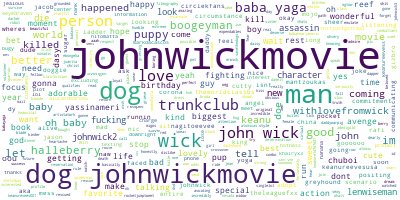

In [96]:
# Join the different processed titles together.
long_string = ','.join(list(characters['text_lemmatized_without_stopwords'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

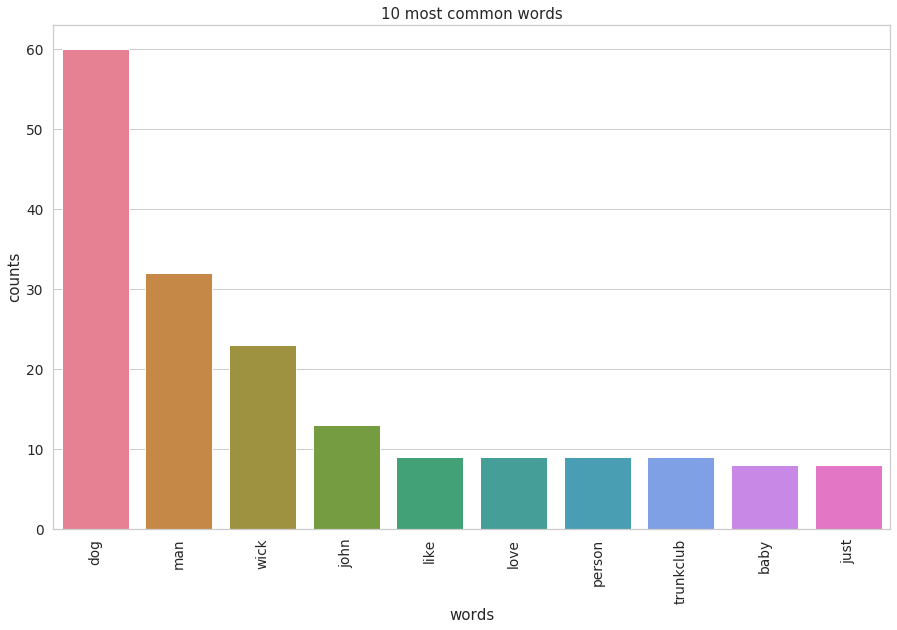

In [97]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['johnwickmovie'])
count_vectorizer = CountVectorizer(stop_words= my_stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(characters['text_lemmatized_without_stopwords'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [114]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
good work did looking lionsgate lionsgatemovies forward baba yaga uk

Topic #1:
wick john mr wait movie watch just like time love

Topic #2:
yes love john wick keanu movie kill oh dog reef

Topic #3:
lenwiseman halleberry imax tarantactical ready bam like come im day

Topic #4:
ikebehar lenwiseman markdacascos let lancereddick halleberry movie waiting oh offiicialkeanur

Topic #5:
like look text ti amo lionsgatemovies kea tweet article quoted

Topic #6:
withlovefromwick happy birthday keanu im el fuck la en asiakatedillon

Topic #7:
shit just awesome withlovefromwick im holy johnwick3 like time shoot

Topic #8:
wait going just yeah time help head lenwiseman oh johnwick3

Topic #9:
im excited excommunicado omg lenwiseman ikebehar want got ready puppy


In [99]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'tm_characters.html')

### General

In [100]:
print('The general sentiment is', round(general['Sentiment_Polarity'].mean(),3))

The general sentiment is 0.144


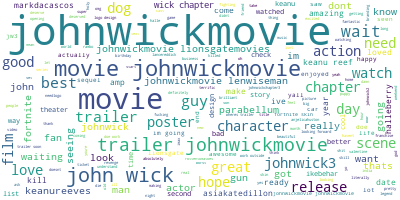

In [101]:
# Join the different processed titles together.
long_string = ','.join(list(general['text_lemmatized_without_stopwords'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

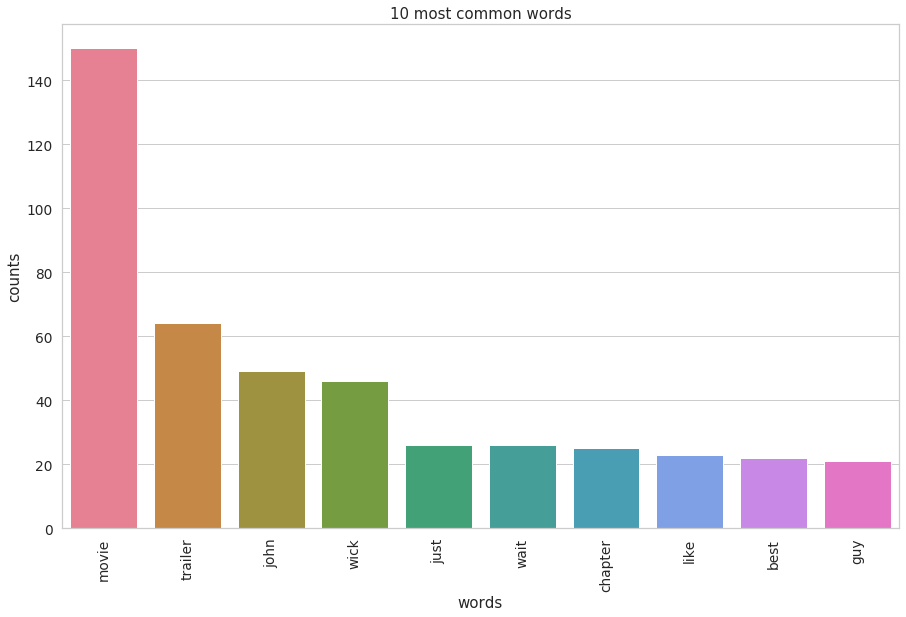

In [102]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['johnwickmovie'])
count_vectorizer = CountVectorizer(stop_words= my_stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(general['text_lemmatized_without_stopwords'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [103]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
movie design best lionsgatemovies great got action enjoyed needlogo logo

Topic #1:
movie like parabellum halleberry film amp hope asiakatedillon watching going

Topic #2:
movie just watch johnwick3 wait day great make valentine saw

Topic #3:
trailer need guy release waiting hope good scene wheres wait

Topic #4:
movie scene dog like doe going action better lionsgatemovies im

Topic #5:
john wick kill going dog chapter johnwick man dont parabellum

Topic #6:
movie john wick fortnite best look ready im action character

Topic #7:
movie chapter just lenwiseman love way keanu know guy actor

Topic #8:
poster movie thats jw3 wait check awesome film just ikebehar

Topic #9:
movie wick john gun date just love like watch lenwiseman


In [104]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'tm_general.html')

### Others

In [105]:
others = movie[movie['aspect'] == 'OTHERS']

In [106]:
print('The general sentiment is', round(others['Sentiment_Polarity'].mean(),3))

The general sentiment is 0.062


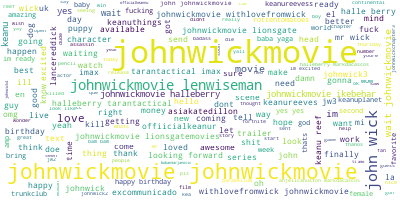

In [110]:
# Join the different processed titles together.
long_string = ','.join(list(others['text_lemmatized_without_stopwords'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

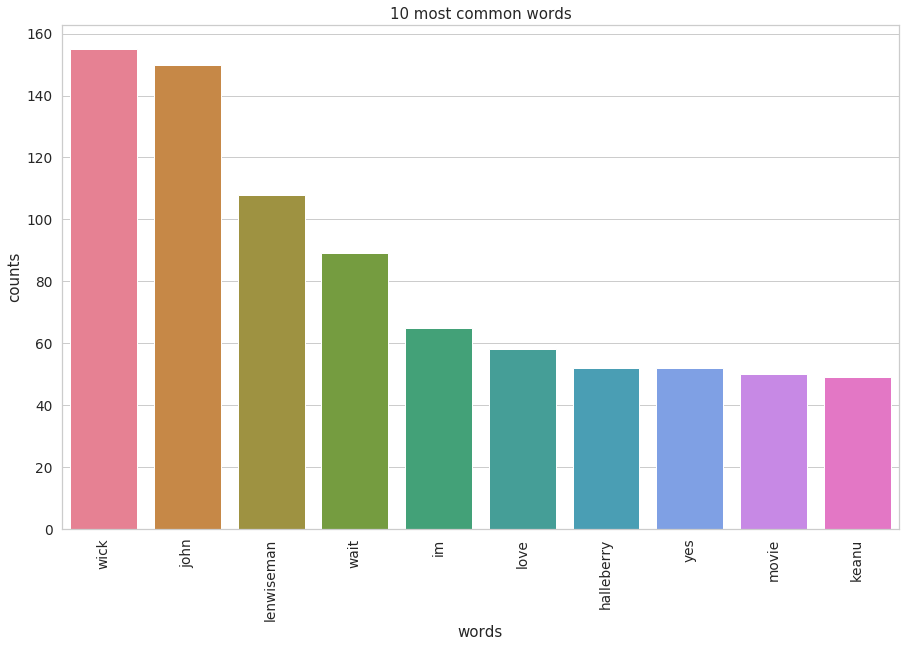

In [111]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['johnwickmovie'])
count_vectorizer = CountVectorizer(stop_words= my_stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(others['text_lemmatized_without_stopwords'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [112]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
halleberry imax tarantactical wait johnwick3 oh shit look bam johnwick

Topic #1:
yes waiting new got lionsgatemovies help loved keanu uk war

Topic #2:
john wick wait love movie keanu finally omg good just

Topic #3:
like john im movie love lionsgatemovies wick tell bring know

Topic #4:
happy keanu birthday reef forward mr looking want seeing come

Topic #5:
lenwiseman going time fuck im movie lionsgatemovies head soon start

Topic #6:
im lenwiseman ready just excited ikebehar yeah wick oh keanu

Topic #7:
excommunicado did lionsgate im lionsgatemovies just hope continental parabellum 91099

Topic #8:
wick john kill awesome let love movie way lionsgate keanu

Topic #9:
withlovefromwick markdacascos lancereddick asiakatedillon halleberry anjelicahuston halle johnwick3 im berry


In [113]:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'tm_others.html')